# Sales Forecasting Project

### Introduction
This project is a comprehensive analysis of Walmart’s weekly sales data, where I worked on forecasting sales for 45 stores across multiple departments. The dataset spans from February 2010 to October 2012 and includes various external factors such as fuel prices, holidays, CPI, and unemployment rates.

My primary goal was to understand the underlying trends, seasonality, and patterns that influence sales and build a reliable forecasting model to predict weekly sales. I paid particular attention to the impact of key holidays like Thanksgiving, Christmas, Super Bowl, and Labor Day, as these are critical for Walmart's revenue.

The main objective of this project was to:

Build a robust model to forecast weekly sales for Walmart stores.
Understand how holidays and other external factors influence sales.
Evaluate model performance using Weighted Mean Absolute Error (WMAE), which prioritizes accurate predictions during holiday weeks.
This project allowed me to explore the challenges of working with real-world retail data, such as handling missing values, detecting outliers, and addressing seasonality.

In [21]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
! pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
pd.options.display.max_columns=100 # to see columns 

In [23]:
df_store = pd.read_csv('dataset/stores.csv') #store data

df_train = pd.read_csv('dataset/train.csv') # train set

df_features = pd.read_csv('dataset/features.csv') #external information

## EXPLORATORY DATA ANALYSIS

In [24]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [25]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [26]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [27]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [28]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column

In [29]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column

In [30]:
df.head() # last ready data set

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [31]:
df.shape

(421570, 16)

# Store & Department Numbers

In [32]:
df['Store'].nunique() # number of different values

45

In [33]:
df['Dept'].nunique() # number of different values

81

Now, I will look at the average weekly sales for each store and each department to see if there is any weird values or not. There are 45 stores and 81 departments for stores. 

In [34]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

Store numbers begin from 1 to 45, department numbers are from 1 to 99, but some numbers are missing such as there is no 88 or 89 etc. Total number of departments is 81. 

From the pivot table, it is obviously seen that there are some wrong values such as there are 0 and minus values for weekly sales. But sales amount can not be minus. Also, it is impossible for one department not to sell anything whole week. So, I will change this values.

In [35]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
846,1,6,2012-08-10,-139.65,False,85.05,3.494,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908,A,151315
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,21290.13,NaN,69.89,4977.35,3261.04,221.671800,7.143,A,151315
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992,B,118221
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,B,118221
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,NaN,NaN,NaN,NaN,NaN,181.692477,8.899,B,118221
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,NaN,NaN,NaN,NaN,NaN,182.318780,8.743,B,118221


In [36]:
df = df.loc[df['Weekly_Sales'] > 0]

In [37]:
df.shape # new data shape

(420212, 16)

# Date

In [38]:
# Combine the first 5 and last 5 rows of the 'Date' column
combined = pd.concat([df['Date'].head(5), df['Date'].tail(5)])
print(combined)


0         2010-02-05
1         2010-02-12
2         2010-02-19
3         2010-02-26
4         2010-03-05
421565    2012-09-28
421566    2012-10-05
421567    2012-10-12
421568    2012-10-19
421569    2012-10-26
Name: Date, dtype: object


Our data is from 5th of February 2010 to 26th of October 2012.  

# IsHoliday column

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

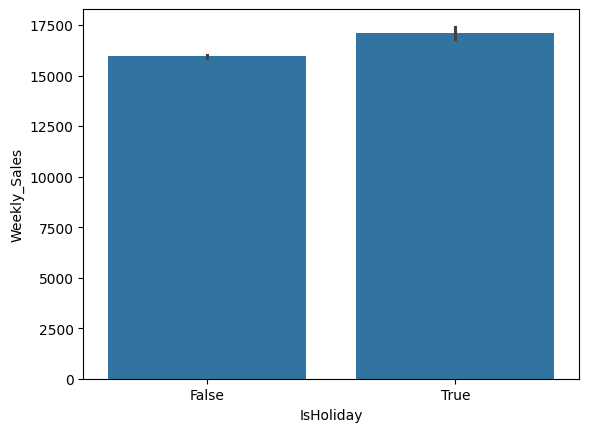

In [39]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [40]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [41]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

### Adding Holiday Indicators
To better understand the impact of holidays on weekly sales, I created new features that indicate whether a particular week includes a major holiday. The holidays considered are Super Bowl, Labor Day, Thanksgiving, and Christmas. These features are binary (True or False) and help capture the holiday effects in the forecasting model.

1. Super Bowl:
The specific dates for Super Bowl in the dataset are February 12, 2010, February 11, 2011, and February 10, 2012.
I added a new column, Super_Bowl, which is set to True for these dates and False otherwise.

2. Labor Day:
The specific dates for Labor Day are September 10, 2010, September 9, 2011, and September 7, 2012.
The column Labor_Day was created with True for these dates and False otherwise.

3. Thanksgiving:
Thanksgiving occurred on November 26, 2010, and November 25, 2011, in the dataset.
The column Thanksgiving marks these dates as True and all others as False.

4. Christmas:
Christmas weeks are represented by December 31, 2010, and December 30, 2011.
I created a column Christmas with True for these dates and False otherwise

In [42]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [43]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [44]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [45]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

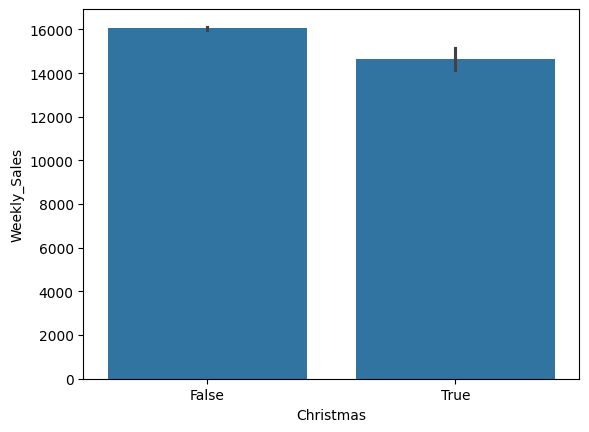

In [46]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

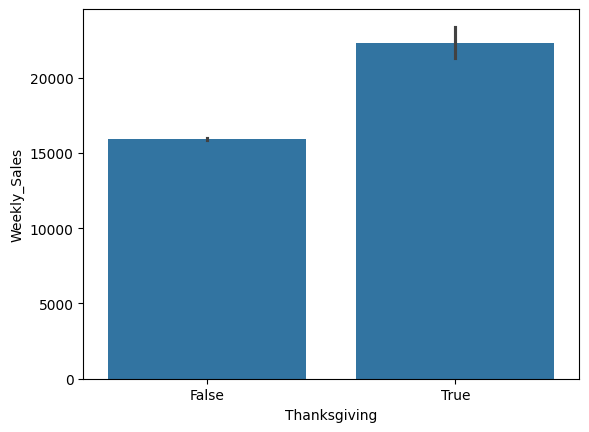

In [47]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

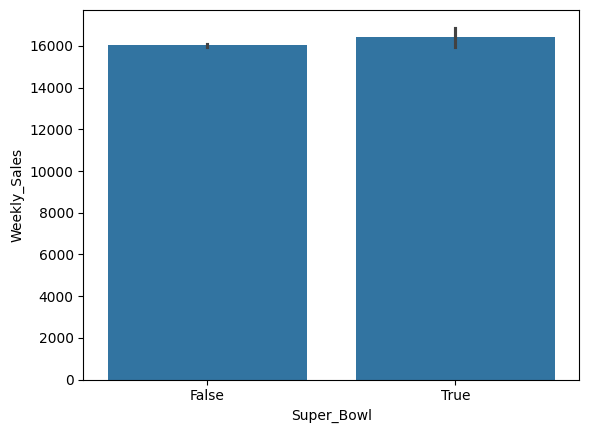

In [48]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

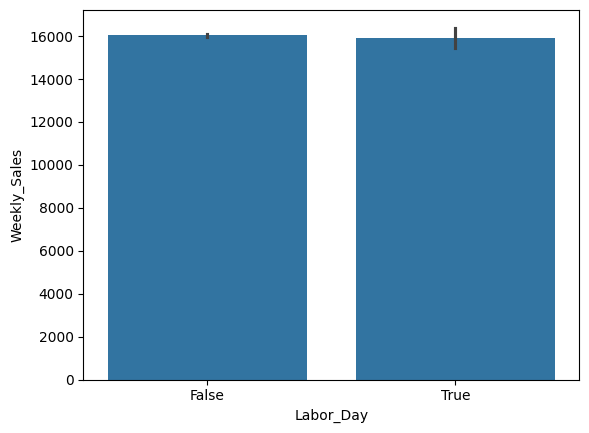

In [49]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

It is shown that for the graphs, Labor Day and Christmas do not increase weekly average sales. There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

# Type Effect on Holidays

There are three different store types in the data as A, B and C.

In [50]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas 

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [51]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [52]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [53]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

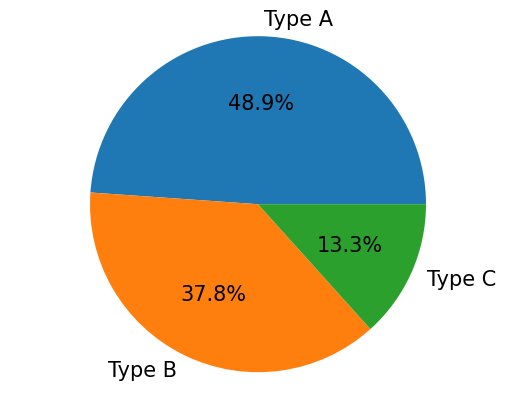

In [54]:
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

In [55]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

Nearly, half of the stores are belongs to Type A.

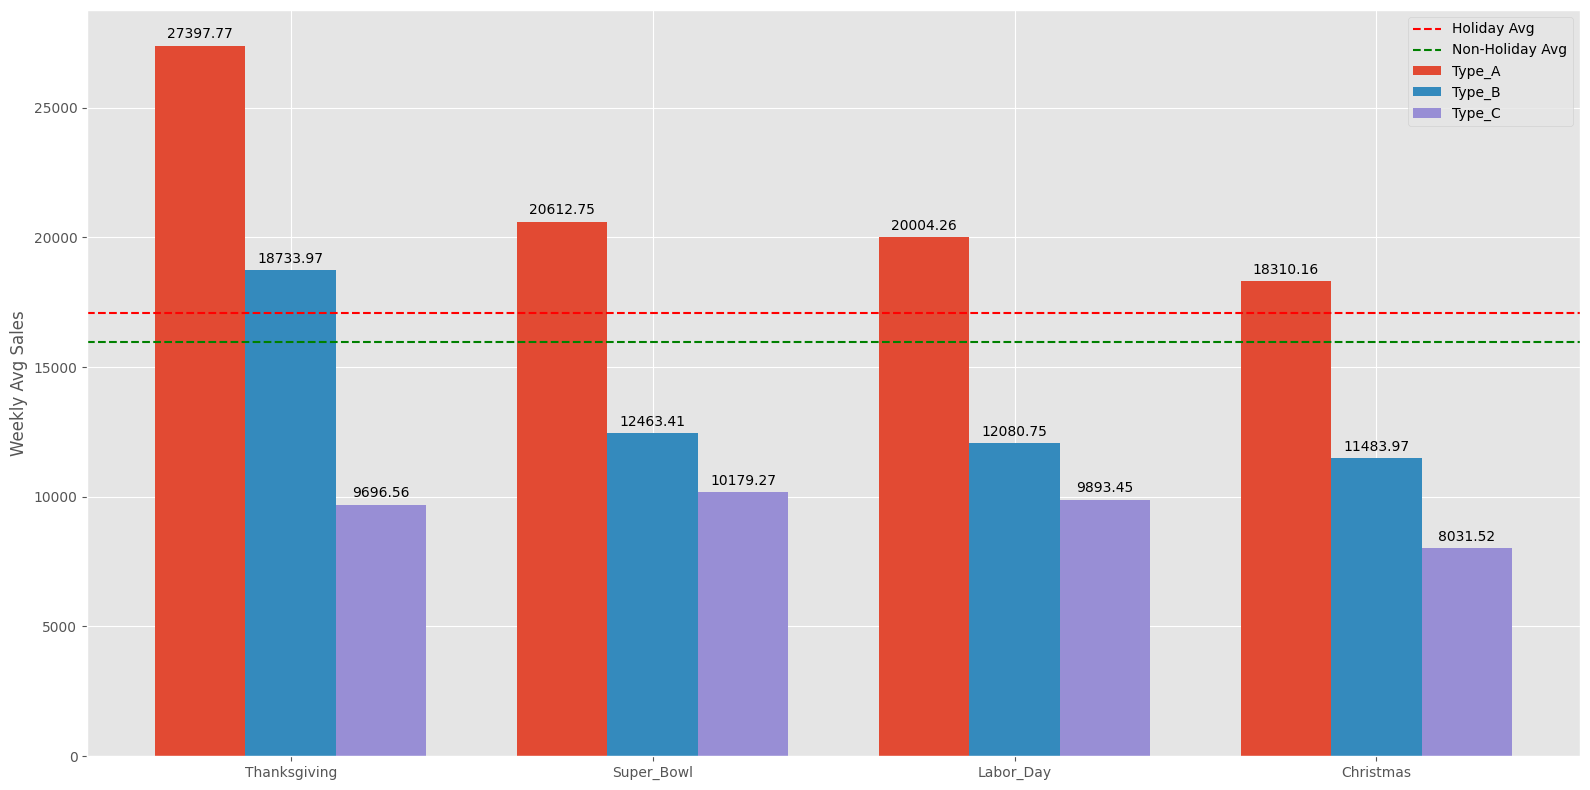

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Data
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56, 10179.27, 9893.45, 8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

# Use 'ggplot' style (or skip this line if unsure)
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x, B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to label bars with their height
def autolabel(rects):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',  # Format to two decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset for text
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Add horizontal lines for average
plt.axhline(y=17094.30, color='red', linestyle='--', label='Holiday Avg')
plt.axhline(y=15952.82, color='green', linestyle='--', label='Non-Holiday Avg')

# Add legend for horizontal lines
ax.legend()

# Tight layout to avoid clipping
fig.tight_layout()

# Show the plot
plt.show()


It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales.

In [58]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
95373,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
338013,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
95425,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
337961,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
135665,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


top 5 highest weekly sales are belongs to Thanksgiving weeks.

# Markdown Columns

Walmart gave markdown columns to see the effect if markdowns on sales. When I check columns, there are many NaN values for markdowns. I decided to change them with 0, because if there is markdown in the row, it is shown with numbres. So, if I can write 0, it shows there is no markdown at that date.

In [61]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [62]:
df = df.fillna(0) # filling null's with 0

In [63]:
df.isna().sum() # last null check

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [64]:
df.describe() # to see weird statistical things

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


Minimum value for weekly sales is 0.01. Most probably, this value is not true but I prefer not to change them now. Because, there are many departments and many stores. It takes too much time to check each department for each store (45 store for 81 departments). So, I take averages for EDA. 

# Deeper Look in Sales

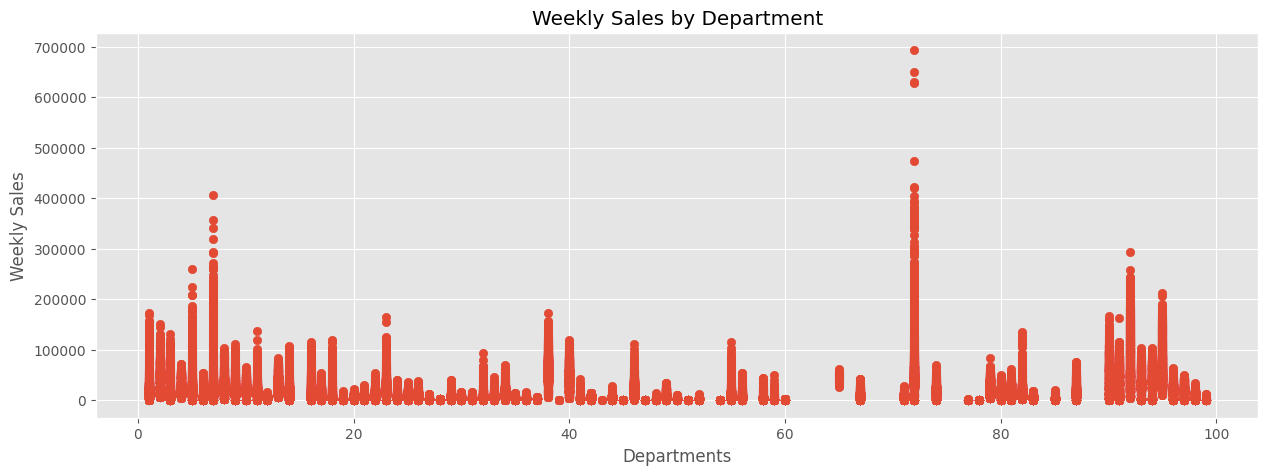

In [65]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

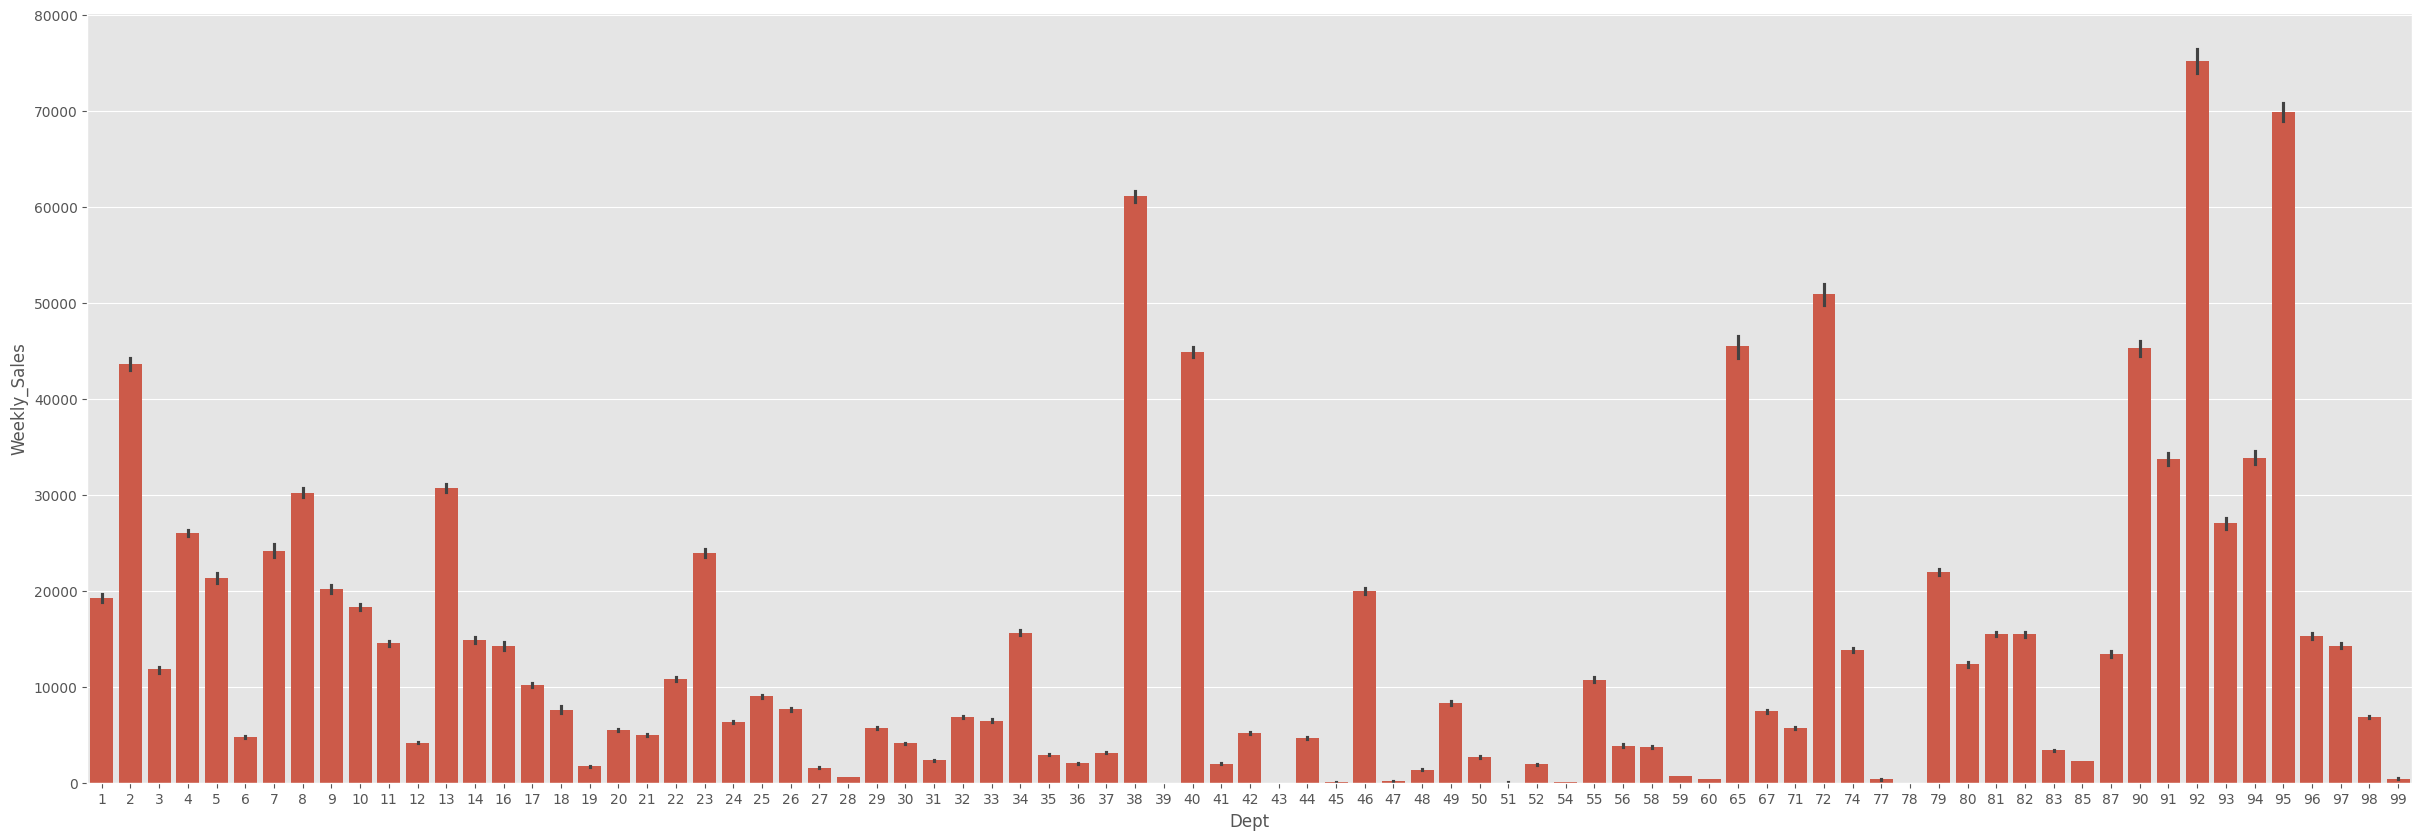

In [66]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

From the first graph, it is seen that one department between 60-80(I assume it is 72), has higher sales values. But, when we take the averages, it is seen that department 92 has higher mean sales. Department 72 is seasonal department, I think. It has higher values is some seasons but on average 92 is higher.

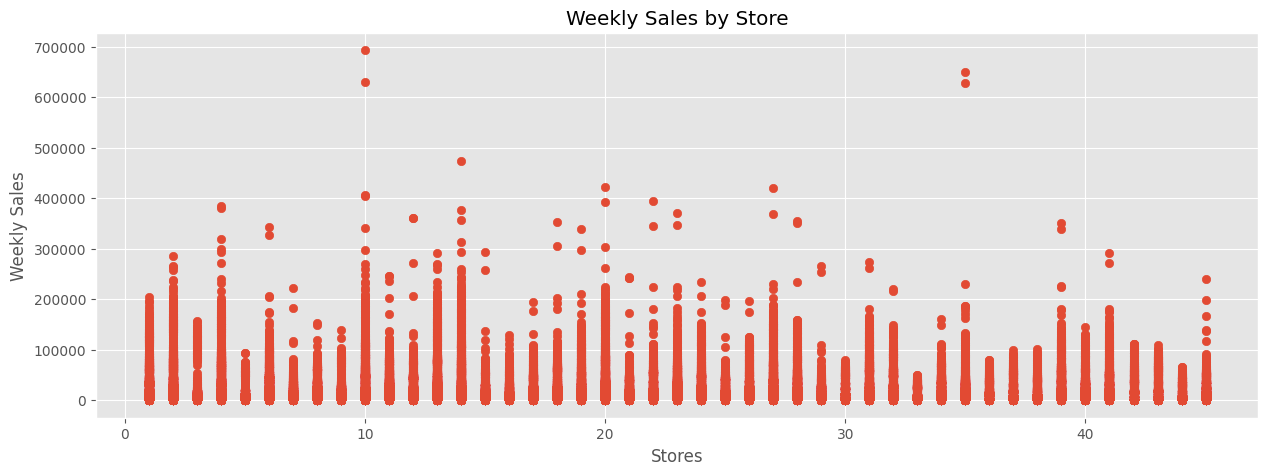

In [67]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

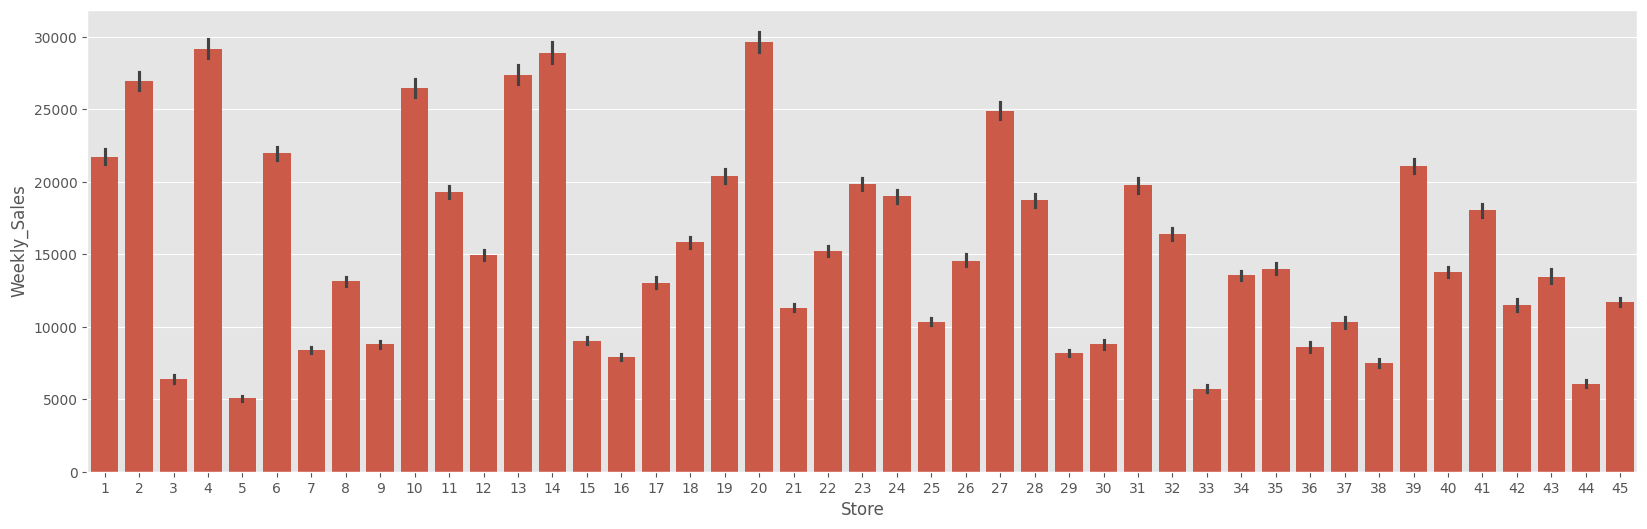

In [68]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

Same thing happens in stores. From the first graph, some stores has higher sales but on average store 20 is the best and 4 and 14 following it.

# Changing Date to Datetime and Creating New Columns

In [70]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] =df['Date'].dt.isocalendar().week
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

In [71]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [72]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

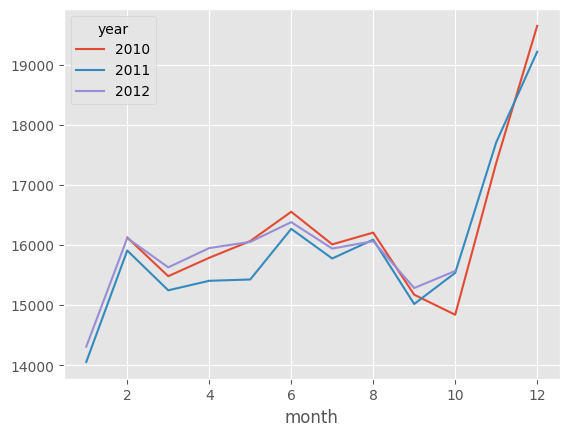

In [73]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales it is seen that 2010 has higher values, but 2012 has no information about November and December which have higher sales. Despite of 2012 has no last two months sales, it's mean is near to 2010. Most probably, it will take the first place if we get 2012 results and add them.

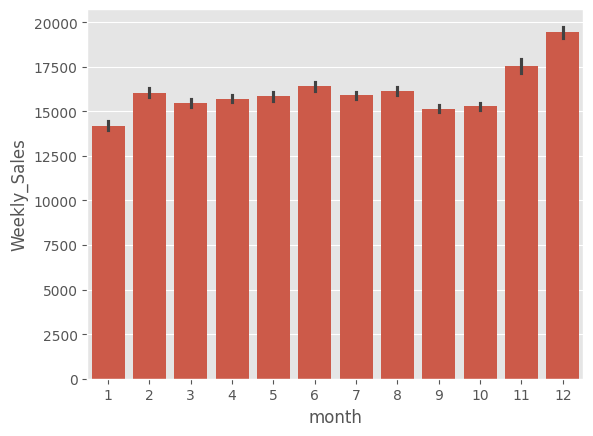

In [74]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

In [75]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed. 

<Axes: xlabel='week'>

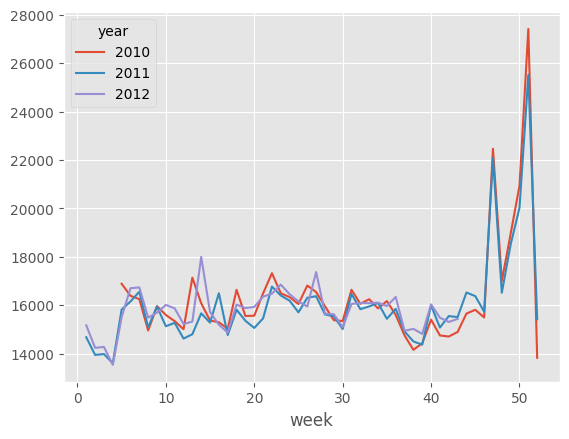

In [76]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

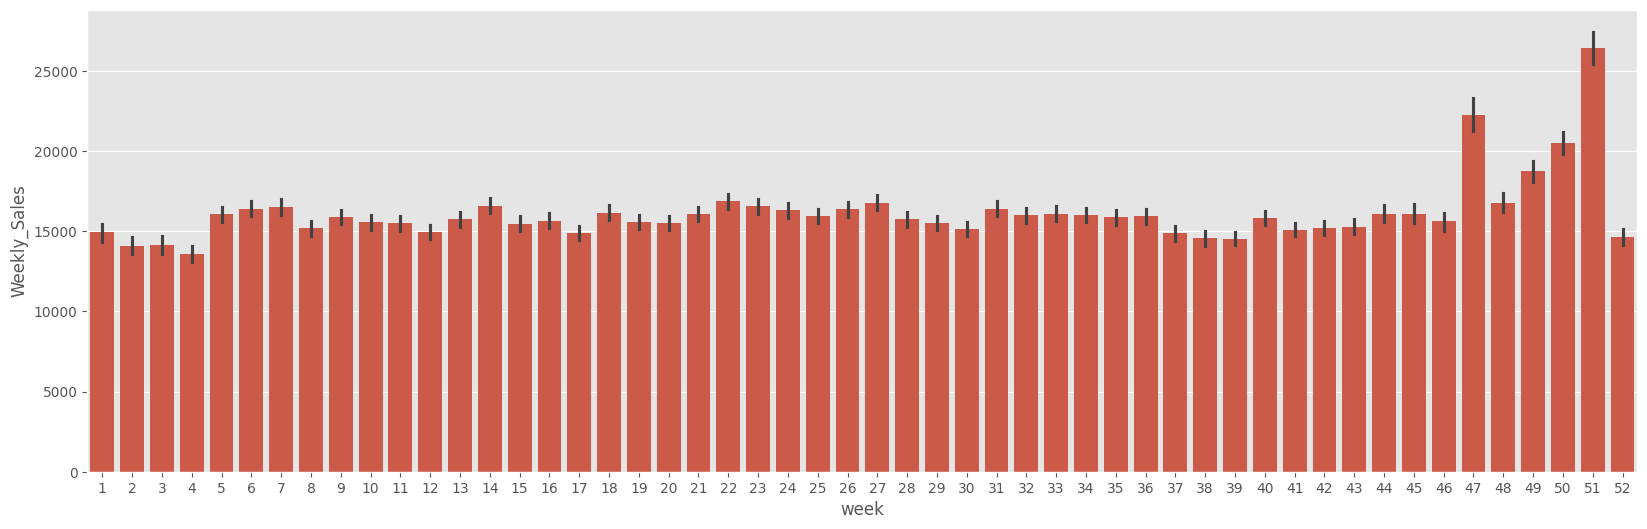

In [77]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

In [82]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

### Observations

The dataset includes 45 stores and 81 departments, but not all departments are present in every store.

1. Department Insights:
Department 72 shows high seasonal sales during Thanksgiving, but department 92 has the highest average sales overall.

2. Store Insights:
Stores 10 and 35 occasionally achieve high weekly sales, but on average, stores 20 and 4 consistently rank highest.
Stores are categorized into types A, B, and C, with Type A (larger stores) contributing the most to sales.

3. Holiday Impact:
Thanksgiving drives the highest sales among holidays, followed by Christmas, where most shopping occurs in the 51st week.

4. Seasonal Trends:
Weeks 47–51 (Thanksgiving to Christmas) dominate sales, with an additional spike in week 22 (end of May, likely due to school holidays).

5. Yearly Trends:
2010 outperformed 2011 and 2012, but missing November-December data for 2012 likely underestimates its performance.

6. Monthly Insights:
November and December show the highest sales, while January is the lowest due to reduced post-holiday spending.

### Experimentations with Random Forest

Generally, Rondom Forest Regressor gives good results when we tune it well. So, to find simple baseline model, I will use RandomForestRegressor in this notebook. Also, feature importance for model can be found in this notebook. 

Our metric for this project is weighted mean absolute error (WMAE):

![title](https://miro.medium.com/max/990/1*VKYKK85ViLYUUjyOWVURfw.jpeg)

where

- n is the number of rows
- ŷ i is the predicted sales
- yi is the actual sales
- wi are weights. w = 5 if the week is a holiday week, 1 otherwise

With this metric, the error at holiday weeks has 5 times weight more than normal weeks. So, it is more important to predict sales at holiday weeks accurately.


In [83]:
pd.options.display.max_columns=100 # to see columns 

In [84]:
df = pd.read_csv('./clean_data.csv')

In [85]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [86]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

# Encoding the Data 

For preprocessing our data, I will change holidays boolean values to 0-1 and replace type of the stores from A, B, C to 1, 2, 3. 

In [87]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [88]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [89]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [90]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

In [91]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1

In [92]:
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1

In [93]:
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [94]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

# Observation of Interactions between Features

Firstly, i will drop divided holiday columns from my data and try without them. To keep my encoded data safe, I assigned my dataframe to new one and I will use for this. 

In [95]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

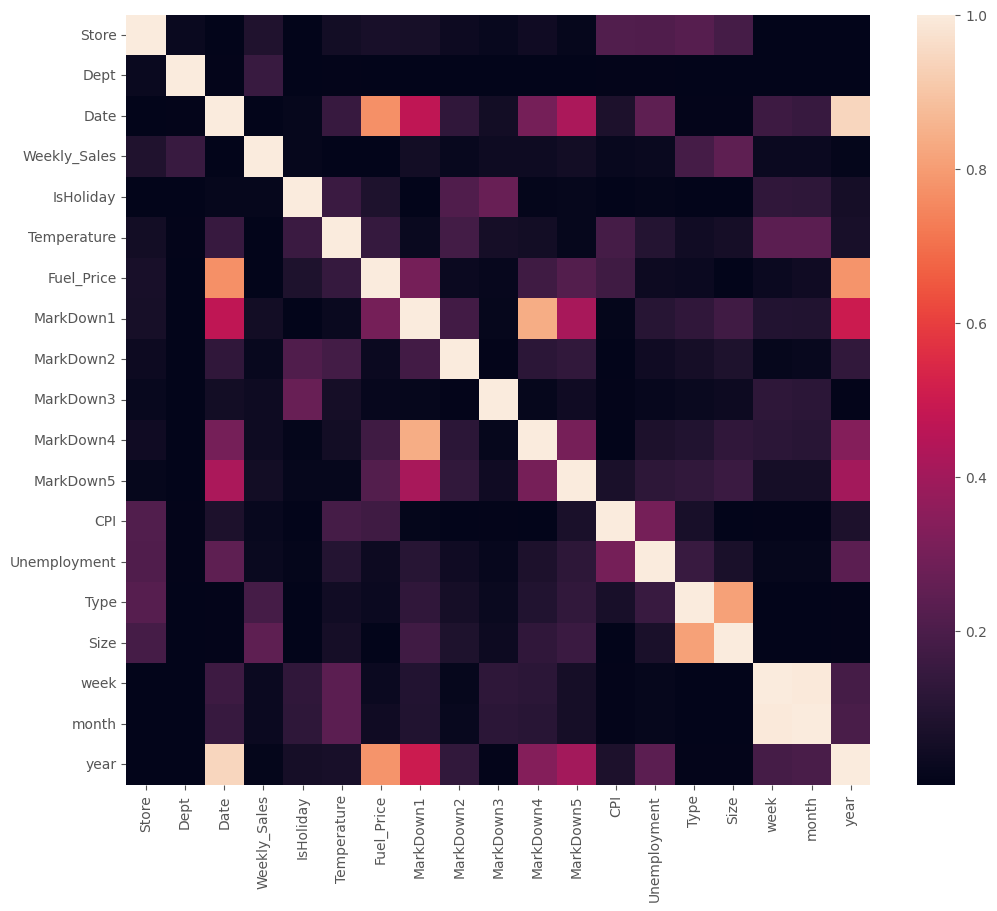

In [96]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

Temperature, unemployment, CPI have no significant effect on weekly sales, so I will drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem, maybe. So, first I will try without them.

In [97]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

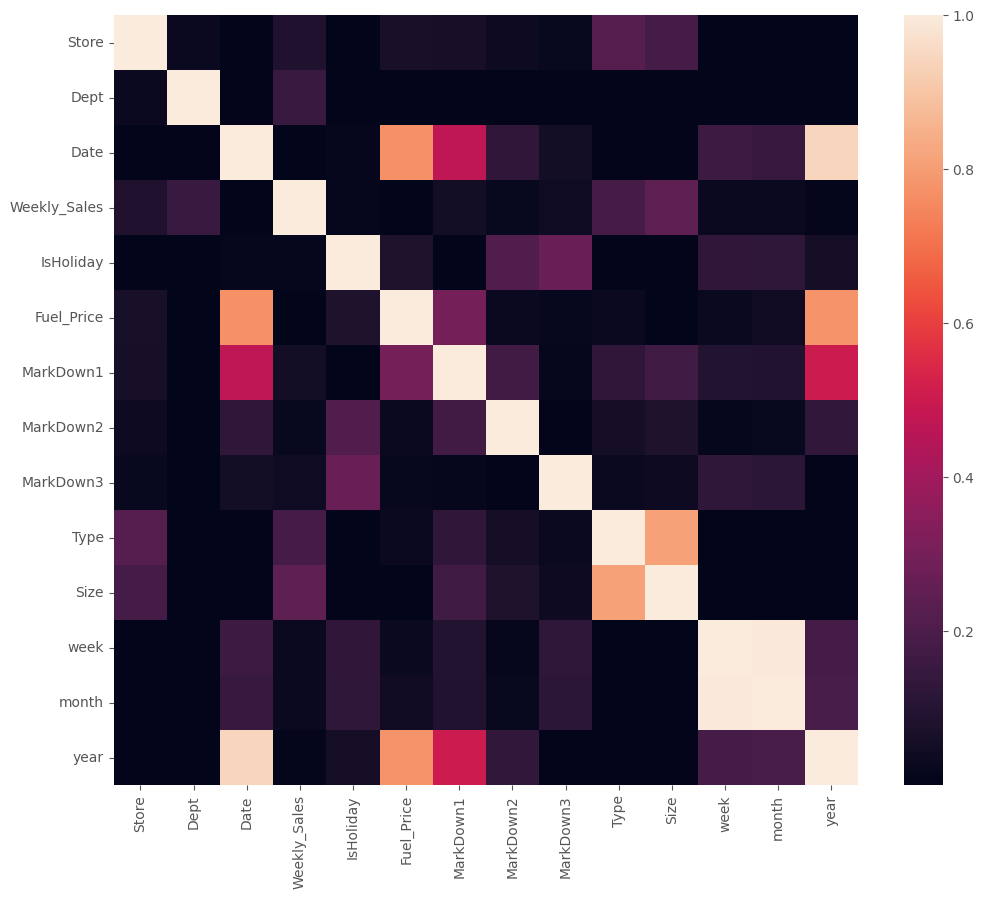

In [98]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations without dropping columns
plt.show()

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

In [99]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

# Creating Train-Test Splits

Our date column has continuos values, to keep the date features continue, I will not take random splitting. so, I split data manually according to 70%.

In [100]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [101]:
X = df_new[used_cols] # to keep train and test X values together

We have enough information in our date such as week of the year. So, I drop date columns.

In [102]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

# Metric Definition Function

Our metric is not calculated as default from ready models. It is weighed error so, I will use function below to calculate it.

In [103]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

# Random Forest Regressor

In [104]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [105]:
wmae_test(y_test, y_pred_test)

5697.712824122053

For the first trial, my weighted error is around 5850.

# To See Feature Importance

In [106]:
X = X.drop(['Date'], axis=1) #dropping date column from X

Feature ranking:
1. feature 1 (0.734834)
2. feature 8 (0.103608)
3. feature 0 (0.058842)
4. feature 7 (0.039401)
5. feature 9 (0.021299)
6. feature 3 (0.018655)
7. feature 10 (0.008636)
8. feature 6 (0.005390)
9. feature 4 (0.003045)
10. feature 5 (0.002715)
11. feature 2 (0.002032)
12. feature 11 (0.001543)


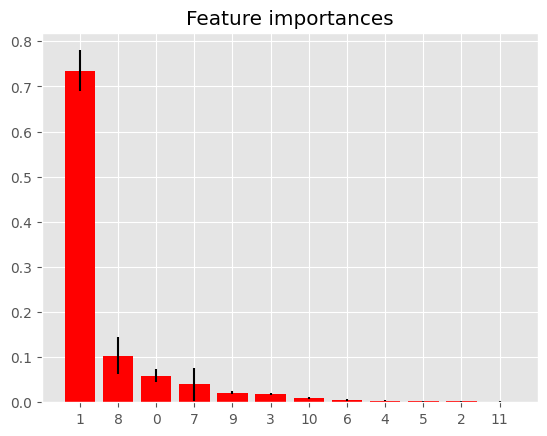

In [107]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

After looking feature importance, I dropped least important 3-4 features and tried the model. I found the best result when I dropped month column which is highly correlated with week.

In [108]:
X1_train = X_train.drop(['month'], axis=1) # dropping month
X1_test = X_test.drop(['month'], axis=1)

# Model Again without Month

In [109]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

# predictions on train set
y_pred = pipe.predict(X1_train)

# predictions on test set
y_pred_test = pipe.predict(X1_test)

In [110]:
wmae_test(y_test, y_pred_test)

5450.408821519322

It gives better results than baseline.

# Model with Whole Data

Now, I want to make sure that my model will learn from the columns which I dropped or not. So, I will apply my model to whole encoded data again.

In [111]:
# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [112]:
X_enc = df_encoded[used_cols1] # to get together train,test splits

In [113]:
X_enc = X_enc.drop(['Date'], axis=1) #dropping date column for whole X

In [114]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) # dropping date from train and test
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [115]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc)

In [116]:
wmae_test(y_test_enc, y_pred_test_enc)

2684.120039795253

We found better results for whole data, it means our model can learn from columns which I dropped before.

# Feature Importance for Whole Encoded Dataset

Feature ranking:
1. feature 1 (0.743021)
2. feature 13 (0.073903)
3. feature 12 (0.040787)
4. feature 0 (0.033258)
5. feature 10 (0.030062)
6. feature 11 (0.017276)
7. feature 18 (0.011946)
8. feature 3 (0.011041)
9. feature 4 (0.010113)
10. feature 19 (0.005986)
11. feature 7 (0.004673)
12. feature 9 (0.003993)
13. feature 8 (0.003554)
14. feature 5 (0.003447)
15. feature 6 (0.002533)
16. feature 20 (0.001175)
17. feature 16 (0.001059)
18. feature 2 (0.000916)
19. feature 17 (0.000683)
20. feature 15 (0.000301)
21. feature 14 (0.000272)


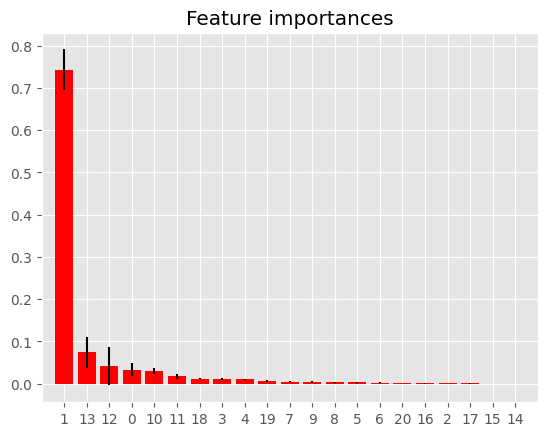

In [117]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

According to feature importance, I dropped some columns from whole set and try my model again.

In [118]:
df_encoded_new = df_encoded.copy() # taking copy of encoded data to keep it without change.
df_encoded_new.drop(drop_col, axis=1, inplace=True)

# Model According to Feature Importance

In [119]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [120]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc1)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc1)

In [121]:
pipe.score(X_test_enc1,y_test_enc1)

0.735025800467954

In [122]:
wmae_test(y_test_enc1, y_pred_test_enc)

2018.8987478432969

I found best results with doing feature selection from whole encoded dataset.

# Model with Dropping Month Column

With the same dateset before, I try to model again without month column. 

In [123]:
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

In [124]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

In [125]:
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

In [126]:
#train-test split
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]] # all columns except price

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

In [127]:
#modeling part
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc2)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc2)

In [128]:
pipe.score(X_test_enc2,y_test_enc2)

0.7104703970074872

In [129]:
wmae_test(y_test_enc2, y_pred_test_enc)

2191.3785727644176

The best results belongs to whole data set with feature selection. Now, I will try time series models.

# Time Series Models

In [132]:
df.head() # to see my data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,True,False,False,False,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,False,False,False,False,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,False,False,False,False,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,False,False,False,False,9,3,2010


In [133]:
df["Date"] = pd.to_datetime(df["Date"]) #changing data to datetime for decomposing

In [134]:
df.set_index('Date', inplace=True) #seting date as index

# Plotting Sales

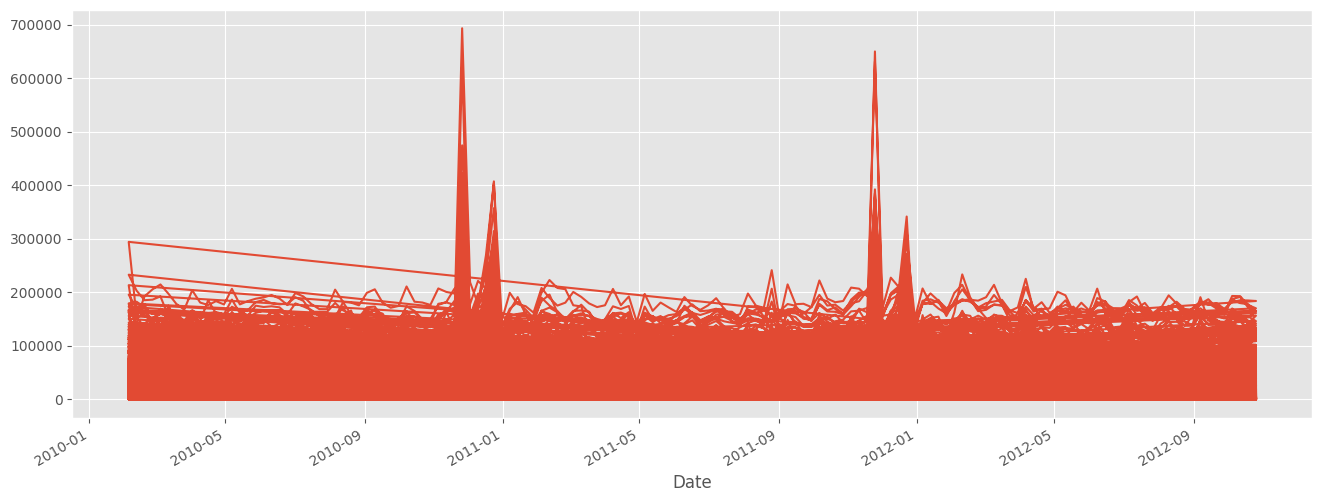

In [135]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In this data, there are lots of same data values. So, I will collect them together as weekly.

In [137]:
# df_week = df.resample('W').mean() #resample data as weekly


# Ensure 'Date' is the index and in datetime format
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

# Resample only numeric columns
df_week = df.select_dtypes(include='number').resample('W').mean()

# Display the result
print(df_week)


                Store       Dept  Weekly_Sales  Temperature  Fuel_Price  \
Date                                                                      
2010-02-07  22.040394  44.161236  16887.602166    33.282800    2.717968   
2010-02-14  22.006443  44.331638  16390.912208    33.370444    2.695955   
2010-02-21  22.044444  44.287542  16255.185970    37.032596    2.673506   
2010-02-28  22.021088  44.058844  14955.932194    38.624806    2.685486   
2010-03-07  22.056199  44.019755  15964.821240    42.367490    2.731923   
...               ...        ...           ...          ...         ...   
2012-09-30  22.227981  44.099932  14815.621125    68.163750    3.858017   
2012-10-07  22.250506  44.518543  16037.442175    65.444187    3.848344   
2012-10-14  22.203760  44.574018  15484.696200    57.678090    3.896989   
2012-10-21  22.258907  44.128266  15311.314544    60.148140    3.878274   
2012-10-28  22.264317  44.134870  15433.541013    60.534436    3.790780   

              MarkDown1 

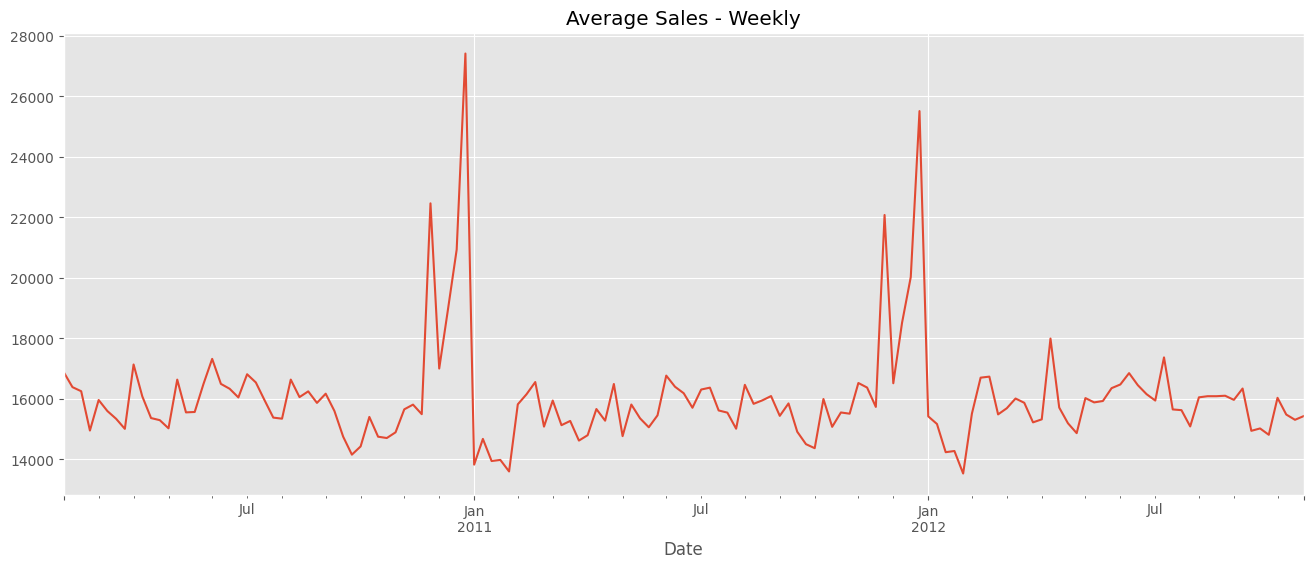

In [138]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [139]:
# df_month = df.resample('MS').mean() # resampling as monthly

# Ensure 'Date' is the index and in datetime format
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

# Resample only numeric columns for monthly data
df_month = df.select_dtypes(include='number').resample('MS').mean()

# Display the result
print(df_month)


                Store       Dept  Weekly_Sales  Temperature  Fuel_Price  \
Date                                                                      
2010-02-01  22.028124  44.210080  16123.339183    35.578510    2.693193   
2010-03-01  22.076498  44.068584  15480.222209    46.695948    2.786435   
2010-04-01  22.087864  44.149396  15786.479121    56.409791    2.867522   
2010-05-01  22.149273  44.298116  16063.976174    64.884550    2.917179   
2010-06-01  22.218080  44.227551  16551.606753    74.595153    2.787978   
2010-07-01  22.186881  44.343681  16009.268745    78.923568    2.773209   
2010-08-01  22.204854  44.199067  16205.333619    78.445074    2.781558   
2010-09-01  22.173913  43.952841  15172.175282    72.300494    2.733204   
2010-10-01  22.168227  43.988452  14839.055563    61.640780    2.807052   
2010-11-01  22.175811  43.949585  17363.277836    49.234671    2.887244   
2010-12-01  22.166383  44.045575  19642.617795    39.123596    2.990936   
2011-01-01  22.136676  43

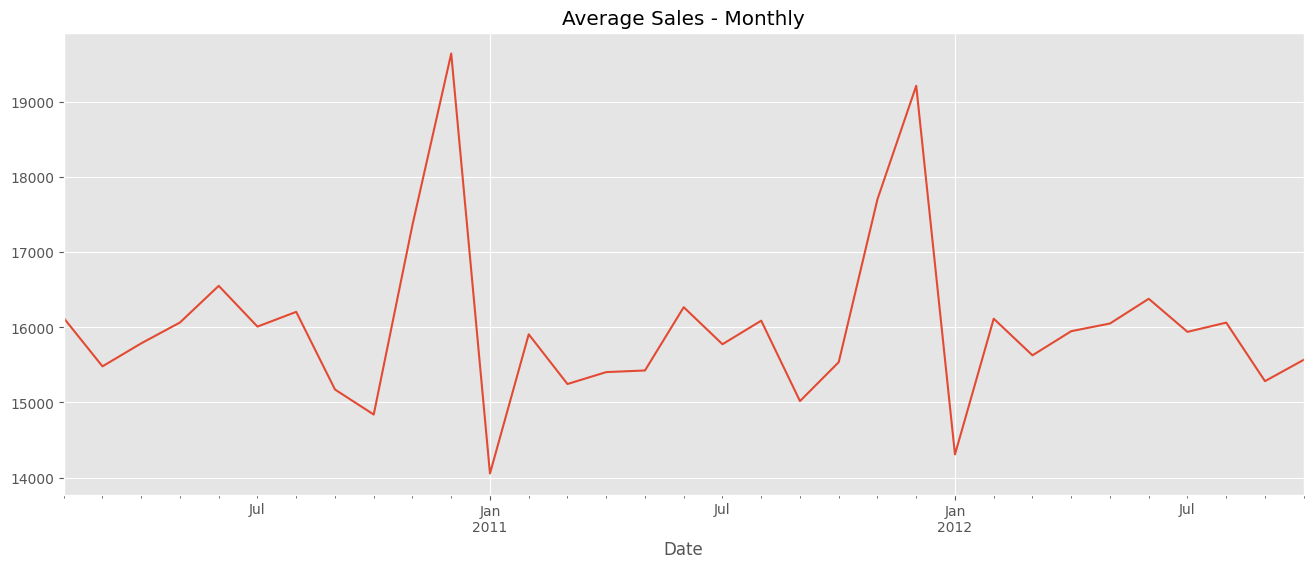

In [140]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

When I turned data to monthly, I realized that I lost some patterns in weekly data. So, I will continue with weekly resampled data.

# To Observe 2-weeks Rolling Mean and Std

My data is non-stationary. So, I will try to find more stationary version on it. 

In [141]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

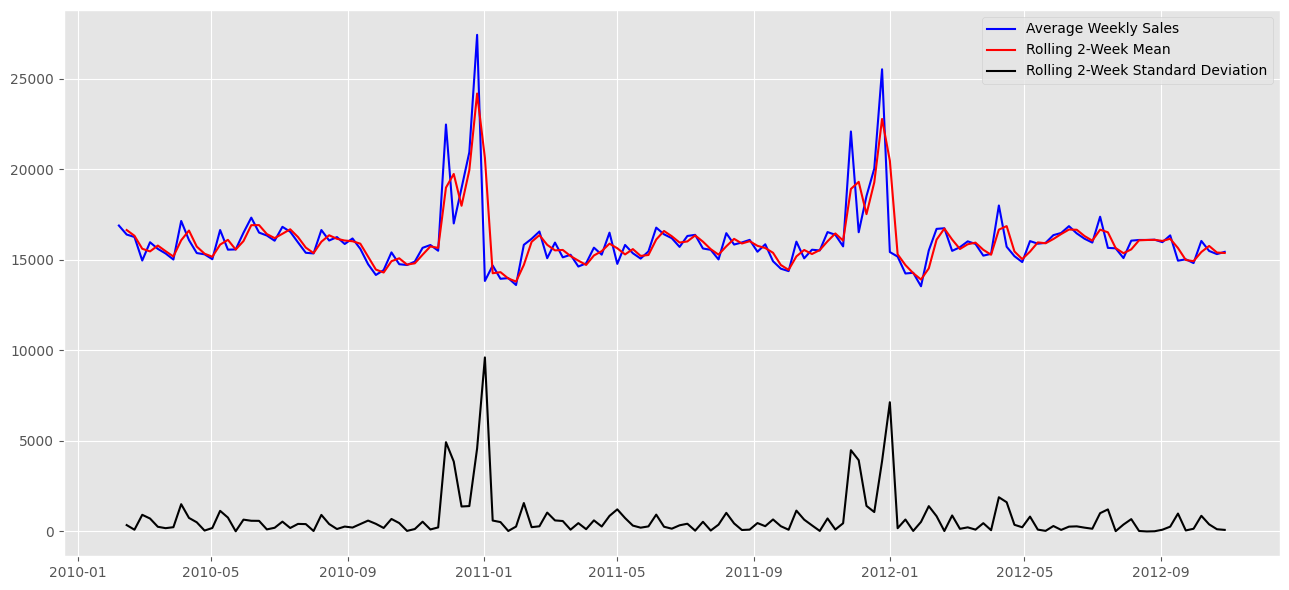

In [142]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

# Adfuller Test to Make Sure

In [143]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737572,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

From test and my observations my data is not stationary. So, I will try to find more stationary version of it.

# Train - Test Split of Weekly Data

To take train-test splits continuosly, I split them manually, not random.

In [144]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 16)
Test: (43, 16)


In [145]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

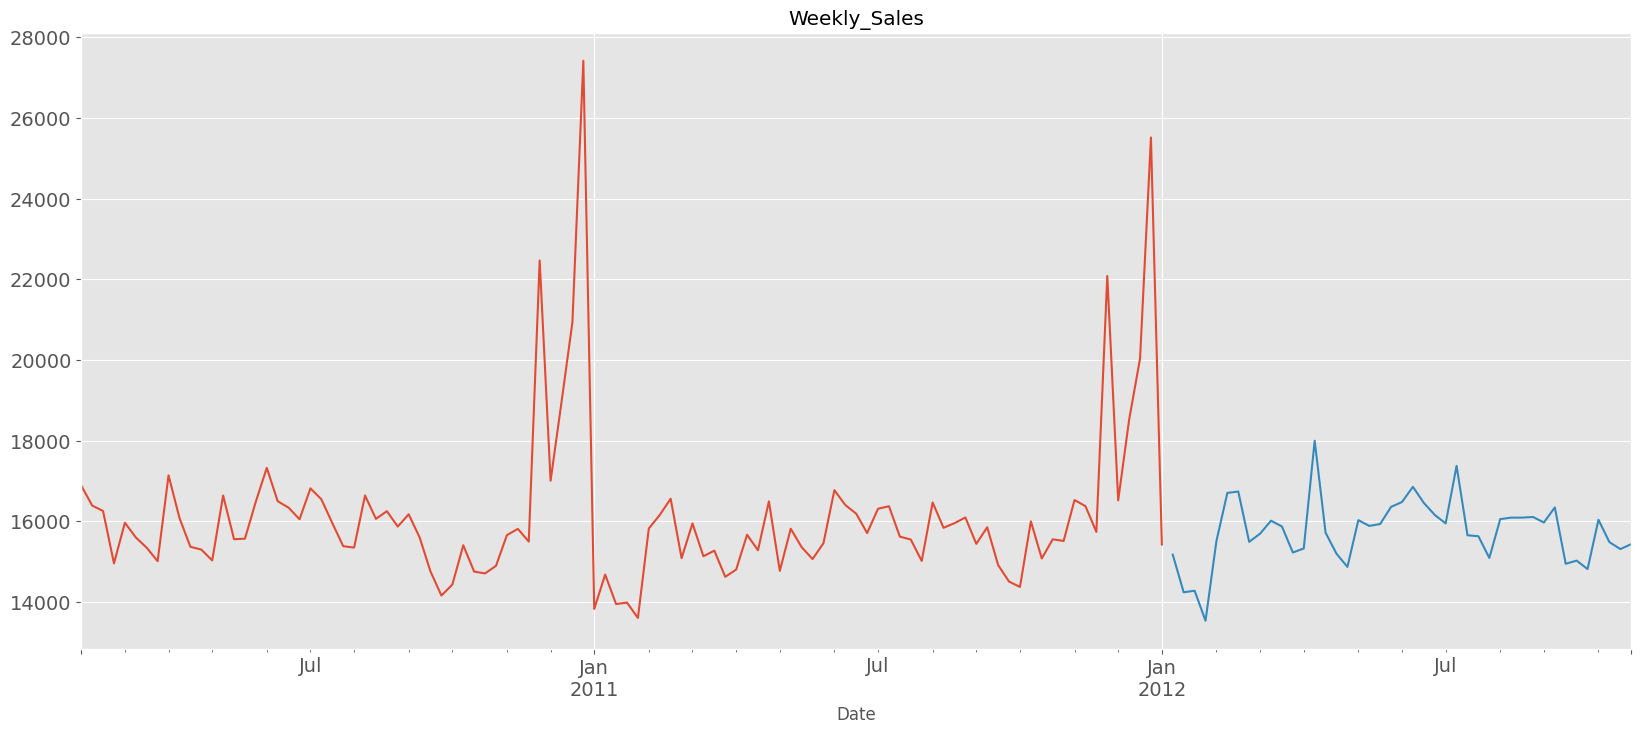

In [146]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

Blue line represents my train data, yellow is test data.

# Decomposing Weekly Data to Observe Seasonality

In [147]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data 

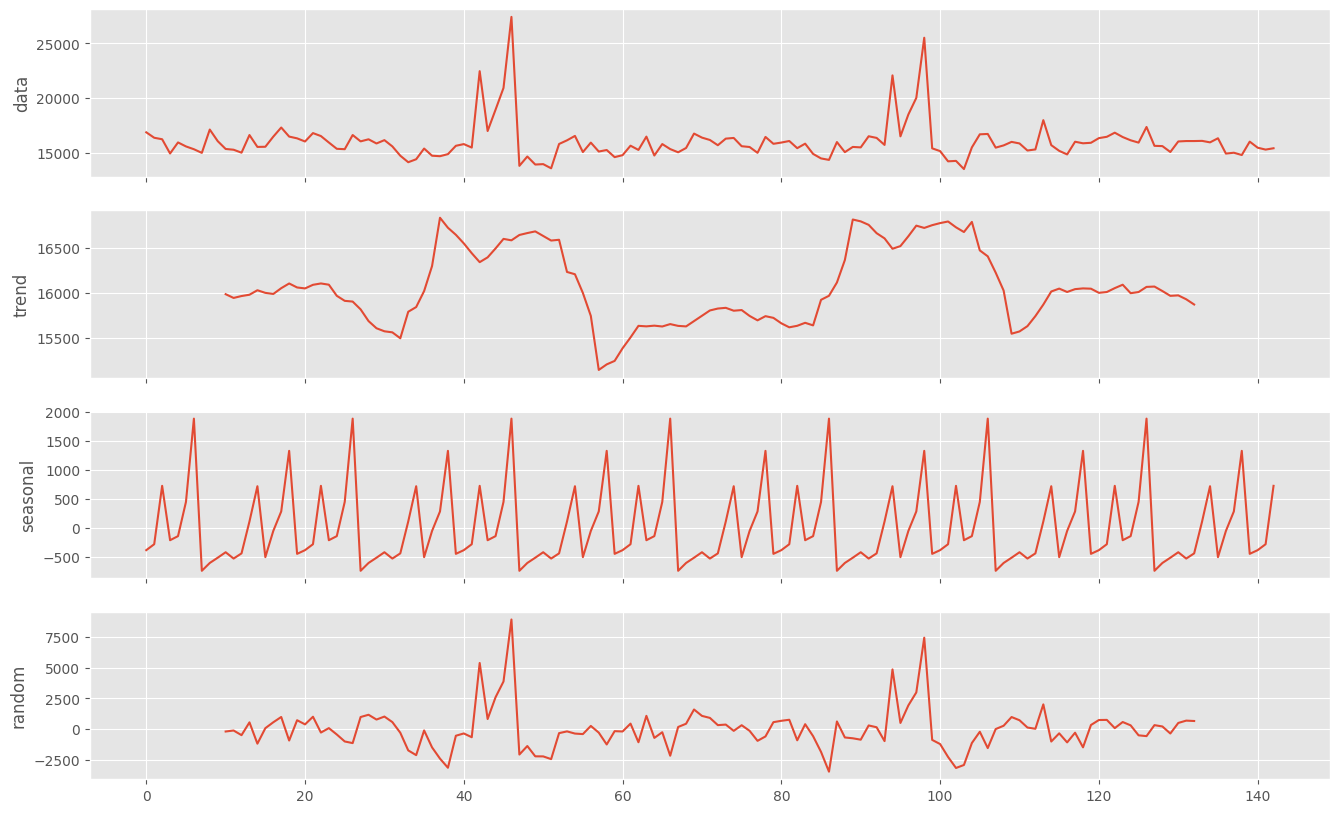

In [148]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps me to tune my model.

# Trying To Make Data More Stationary

Now, I will try to make my data more stationary. To do this, I will try model with differenced, logged and shifted data.

## 1. Difference

In [149]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [150]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

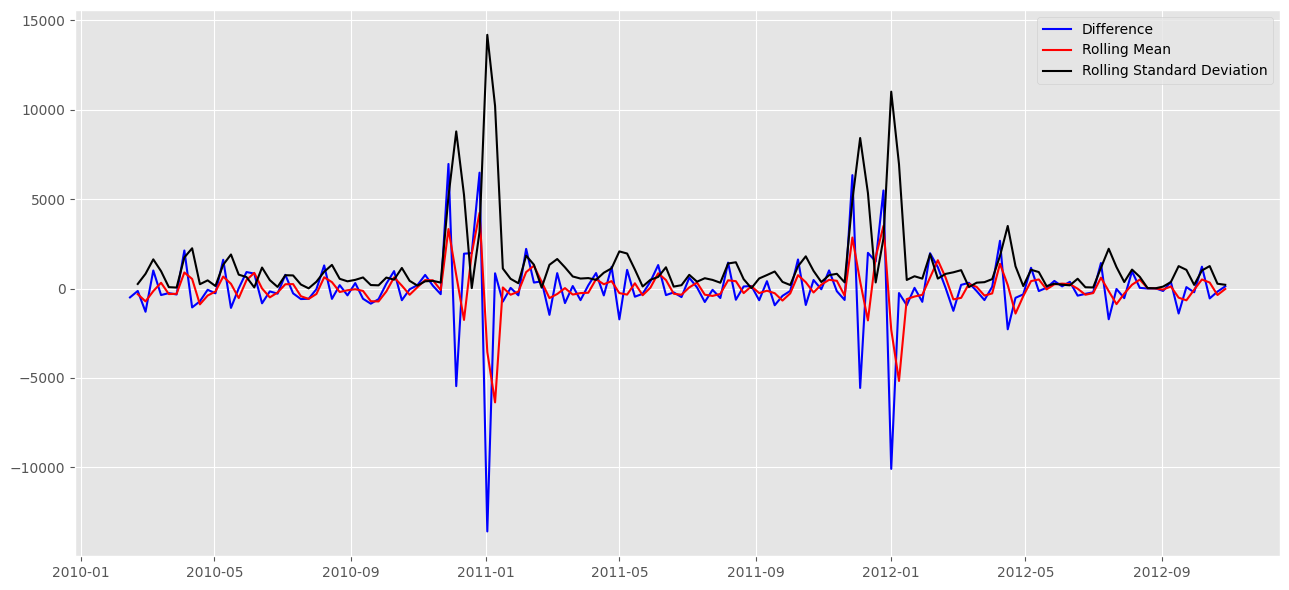

In [151]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 2.Shift

In [152]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data 

In [153]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

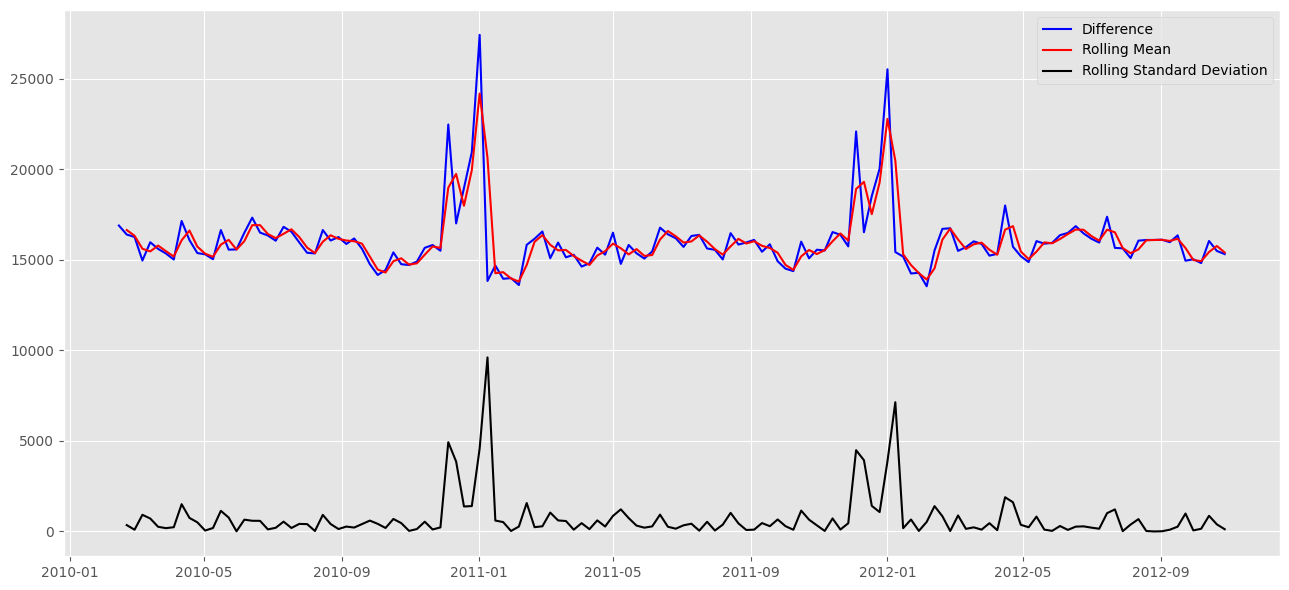

In [154]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 3.Log

In [155]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [156]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

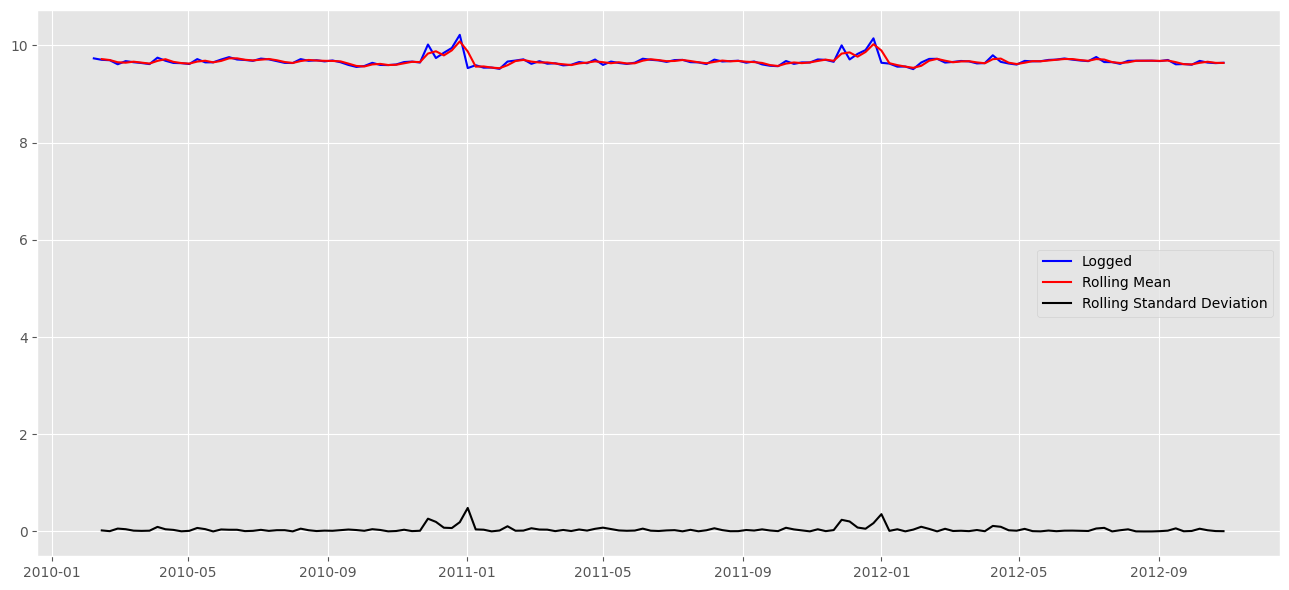

In [157]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

# Auto-ARIMA MODEL

I tried my data without any changes, then tried with shifting, taking log and difference version of data. Differenced data gave best results. So, I decided to take difference and use this data. 

# Train-Test Split

In [158]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [159]:
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.23 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

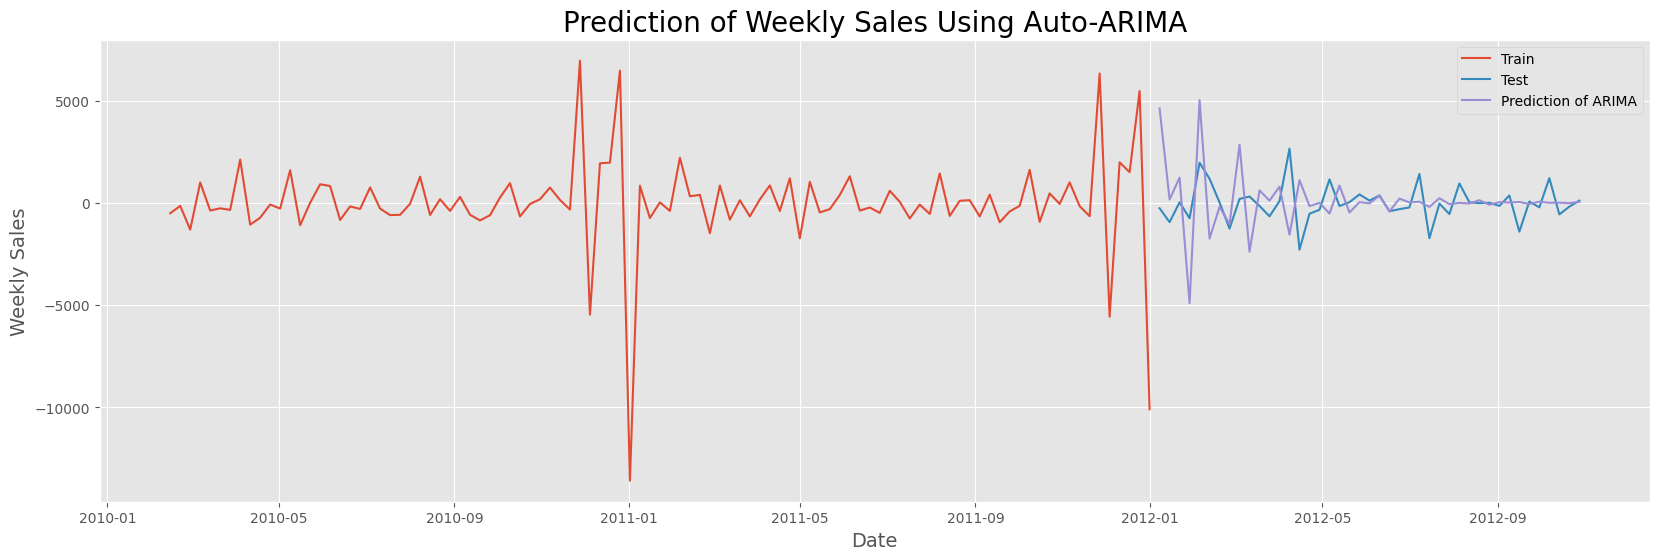

In [160]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

# ExponentialSmoothing

I checked suitable Holt-Winters models according tp my data. Exponential Smooting are used when data has trend, and it flattens the trend. The damped trend method adds a damping parameter so, the trend converges to a constant value in the future. 

My difference data has some minus and zero values, so I used additive seasonal and trend instead of multiplicative. Seasonal periods are chosen from the decomposed graphs above. For tuning the model with iterations take too much time so, I changed and tried model for different parameters and found the best parameters and fitted them to model.

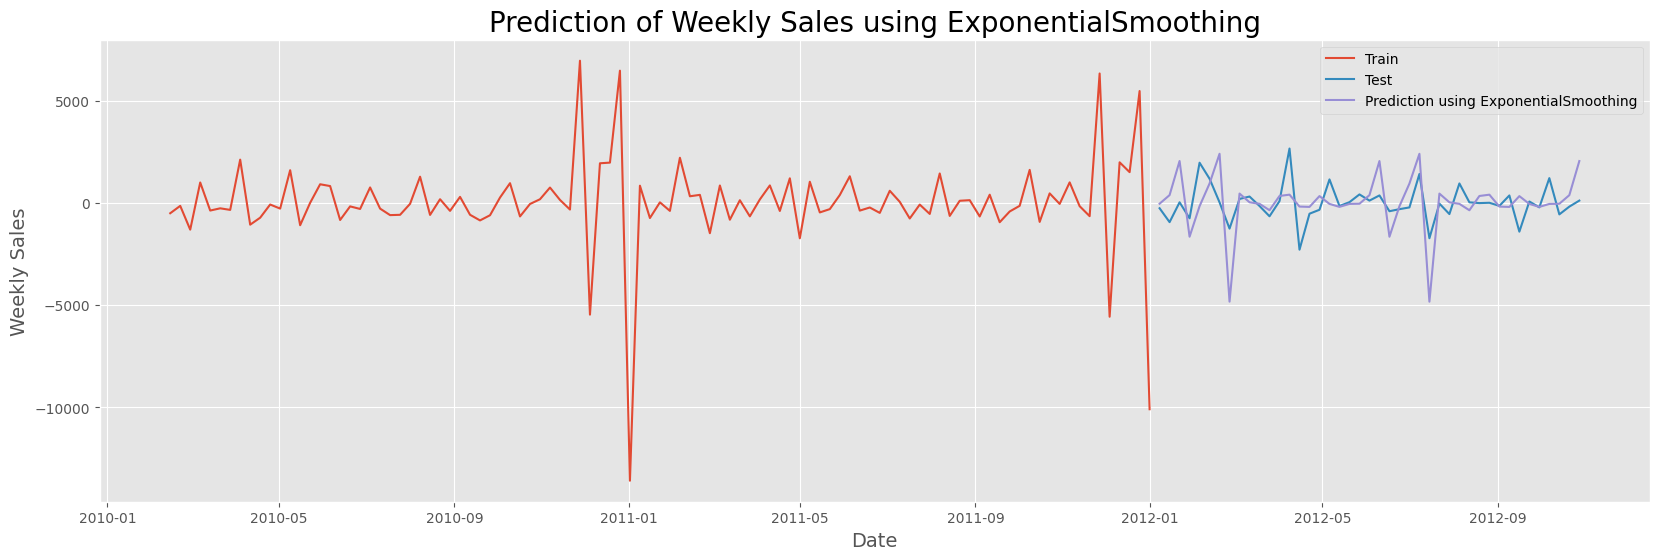

In [161]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


At the end, I found best results for my data with Exponential Smoothing Model.